# 
This project is to predict power consumption of a commercial building in Florida. The dataset contains outside air temperature and  power consumptions with 15mins timestep in the year of 2010. 
Firstly, we did lag for OAT to find if there are any useful correlation with power consumption. 
Then, we created time features including weekends, weekday, night and so on. 
Thirdly, we perform the data prediction in four different methods including linear regression split, cross validation, support vector machines and Random Forest Regressor. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#importing the data file and creating a dataframe 
DataFolderPath="/Users/chenrujing/Dropbox/"
ConsumptionFileName= "building5retail.csv"
ConsumptionFilePath = DataFolderPath+"/"+ConsumptionFileName 

ConsumptionFileName = "building5retail.csv"
ConsumptionFilePath= DataFolderPath+"/"+ConsumptionFileName
DF_consumption = pd.read_csv(ConsumptionFilePath,sep=",",index_col=0)
previousIndex= DF_consumption.index
NewparsedIndex = pd.to_datetime(previousIndex)
DF_consumption.index= NewparsedIndex
DF_consumption.head(24)
DF_JulyfirstTillthird = DF_consumption["2010-07-01 00:00:00":"2010-07-03 23:00:00"]
DF_JulyfirstTillthird.head(5)
DF_JulyfirstTillthird.describe()

,OAT (F),Power (kW)
count,285.000000,285.000000
mean,82.042105,372.624912
std,4.387681,85.094334
min,75.000000,215.700000
25%,78.000000,280.000000
50%,81.000000,410.000000
75%,85.000000,440.200000
max,91.000000,503.700000


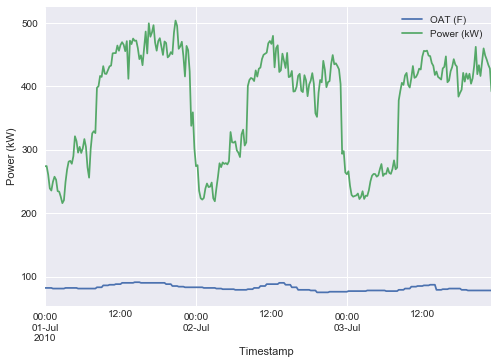

In [4]:
DF_JulyfirstTillthird.plot()
plt.xlabel('Timestamp ')
plt.ylabel('Power (kW)')
plt.show()

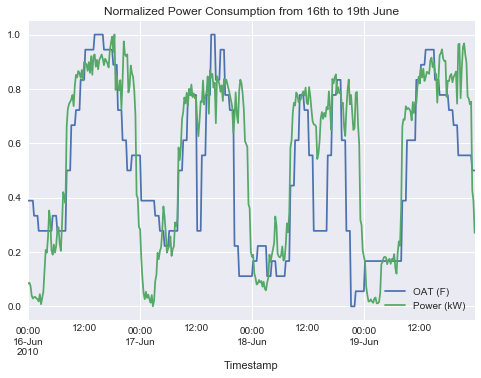

In [12]:
DF_consumption = DF_consumption.dropna()

# comparingtogether

df_chosen_dates = DF_consumption['2010-06-16':'2010-06-19']
df_chosen_dates_normalized = (df_chosen_dates- df_chosen_dates.min())/(df_chosen_dates.max()-df_chosen_dates.min())
df_chosen_dates_normalized.plot()
plt.title("Normalized Power Consumption from 16th to 19th June")
plt.show()

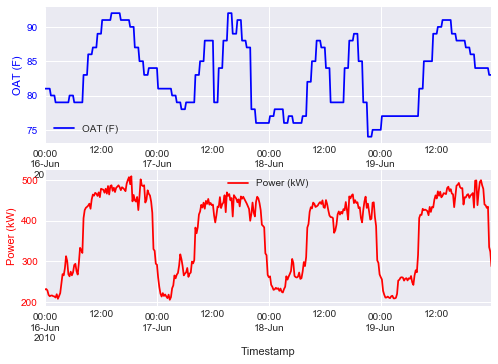

In [19]:
#Graph2, compare in two graphs seperately
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
df_chosen_dates.iloc[:,0].plot(ax=ax1,legend=True,color="b")
df_chosen_dates.iloc[:,1].plot(ax=ax2,legend=True,color="r")
ax1.set_ylabel(" OAT (F) ", color="b")
ax2.set_ylabel(" Power (kW)", color="r")
ax1.tick_params(axis='y',colors='b')
ax2.tick_params(axis='y',colors='r')
plt.show()



In [20]:
#lagged the data

def lag_column(df,column_name,lag_period=1):
    for i in range(1,lag_period+1,1):
        new_column_name = column_name+" -"+str(i)+"hr"
        df[new_column_name]=(df[column_name]).shift(i)
    return df

df_FinalDataSet_withLaggedFeatures = DF_consumption.copy()
df_FinalDataSet_withLaggedFeatures = lag_column(df_FinalDataSet_withLaggedFeatures,"OAT (F)",24)
df_FinalDataSet_withLaggedFeatures.head(24)
df_FinalDataSet_withLaggedFeatures.dropna(inplace=True)

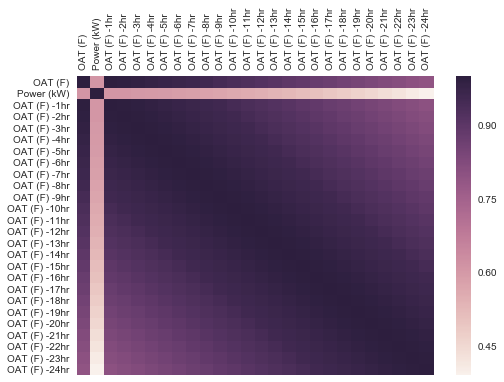

In [23]:
#plot lagged correlation data
fig = plt.figure("Figure for Correlations between all the lagged temperature and power consumption")
plot = fig.add_axes()
plot = sns.heatmap(df_FinalDataSet_withLaggedFeatures.corr(), annot=False)
plot.xaxis.tick_top() 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

From the plot, it doesn't show lag features, so the time matches.

In [24]:

#creatures creating

def features_creation(df):

    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek #
    df['weekend'] = [ 1 if day in (5, 6) else 0 for day in df.index.dayofweek ] 
    df['month'] = df.index.month
    df['week_of_year'] = df.index.week
    df['day_night'] = [1 if day<20 and day>9 else 0 for day in df.index.hour ]
    return df
    
df_FinalDataSet  = DF_consumption.copy()

df_FinalDataSet['hour'] = df_FinalDataSet.index.hour
df_FinalDataSet['day_of_week'] = df_FinalDataSet.index.dayofweek 
df_FinalDataSet['month'] = df_FinalDataSet.index.month
df_FinalDataSet['week_of_year'] = df_FinalDataSet.index.week

In [25]:
#List Comprehension   
def DayDetector(hour):
    dayLabel=1
    if (hour<20 and hour > 9):
        dayLabel = 1
    else:
        dayLabel = 0
    return dayLabel

df_FinalDataSet['day_night'] = [DayDetector(thisHour) for thisHour in df_FinalDataSet.index.hour] # day = 1 if(10Hrs -19Hrs) and Night = 0 (otherwise

def WeekendDetector(day):
    weekendLabel = 0
    if (day==5 or day==6):
        weekendLabel = 1
    else:
        weekendLabel=0
    return weekendLabel
df_FinalDataSet['weekend'] = [ WeekendDetector(thisDay) for thisDay in df_FinalDataSet.index.dayofweek ] # 1 for weekend and 0 for weekdays
df_FinalDataSet.head()
df_FinalDataSet.describe()

,OAT (F),Power (kW),hour,day_of_week,month,week_of_year,day_night,weekend
count,34940.000000,34940.000000,34940.000000,34940.000000,34940.000000,34940.000000,34940.000000,34940.000000
mean,73.798626,334.651746,11.501288,2.999886,6.511935,26.505180,0.416714,0.285747
std,11.215433,95.045358,6.921634,2.000114,3.440349,15.020951,0.493022,0.451776
min,33.000000,77.600000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,68.000000,252.700000,6.000000,1.000000,4.000000,13.000000,0.000000,0.000000
50%,76.000000,350.100000,12.000000,3.000000,7.000000,26.000000,0.000000,0.000000
75%,82.000000,418.000000,18.000000,5.000000,10.000000,39.000000,1.000000,1.000000
max,94.000000,558.100000,23.000000,6.000000,12.000000,53.000000,1.000000,1.000000


In [26]:
#Normalize the data
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

DF_target = df_FinalDataSet["Power (kW)"]
DF_features = df_FinalDataSet.drop("Power (kW)",axis=1)

df_FinalDataSet_norm = normalize(df_FinalDataSet)
DF_target_norm = df_FinalDataSet_norm["Power (kW)"]
DF_features_norm = df_FinalDataSet_norm.drop("Power (kW)",axis=1)

In [37]:
#methoads of prediction

#Method1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DF_features, DF_target, test_size=0.2, random_state=41234)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(DF_features_norm, DF_target_norm, test_size=0.2, random_state=41234)

from sklearn import linear_model
linear_reg = linear_model.LinearRegression()

linear_reg.fit(X_train, y_train)
predict_linearReg_split= linear_reg.predict(X_test)
predict_DF_linearReg_split=pd.DataFrame(predict_linearReg_split, index = y_test.index,columns=["Power_ConsPred_linearReg_split"])

predict_DF_linearReg_split = predict_DF_linearReg_split.join(y_test)


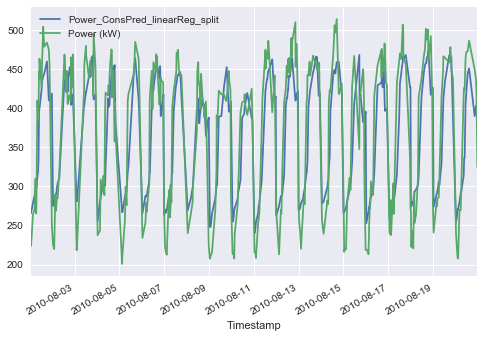

In [51]:
predict_DF_linearReg_split['2010-08-01':'2010-08-20'].plot()
plt.show()





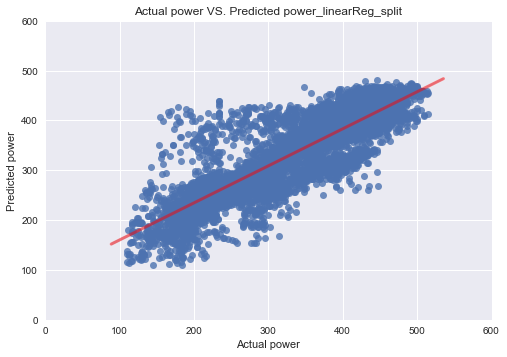

In [54]:
import seaborn as sns
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot = sns.regplot(x="Power (kW)", y="Power_ConsPred_linearReg_split",
                   data=predict_DF_linearReg_split,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Actual power VS. Predicted power_linearReg_split')
plot.set_xlim([0,600])
plot.set_ylim([0,600])
plot.set_xlabel('Actual power')
plot.set_ylabel('Predicted power')
regline = plot.get_lines()[0];
regline.set_color('red')
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
metric_R2_score = r2_score(y_test,predict_linearReg_split)
metric_mean_absolute_error = mean_absolute_error(y_test,predict_linearReg_split)
metric_mean_squared_error = mean_squared_error(y_test,predict_linearReg_split)
coeff_variation = np.sqrt(metric_mean_squared_error)/y_test.mean()
print "coefficient_variation of linear regression split is " + str (coeff_variation) 

coefficient_variation of linear regression split is 0.142520913495


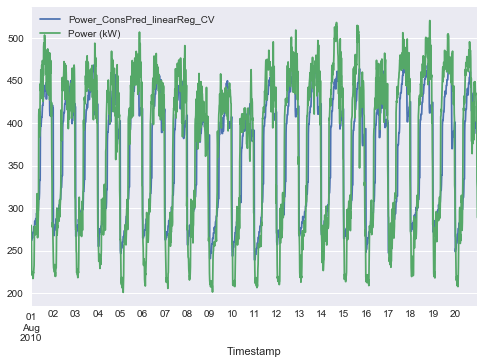

In [61]:
#Method2 Cross Validation
from sklearn.model_selection import cross_val_predict
predict_linearReg_CV = cross_val_predict(linear_reg,DF_features,DF_target,cv=10)
predict_DF_linearReg_CV=pd.DataFrame(predict_linearReg_CV, index = DF_target.index,columns=["Power_ConsPred_linearReg_CV"])
predict_DF_linearReg_CV = predict_DF_linearReg_CV.join(DF_target)
predict_DF_linearReg_CV['2010-08-01':'2010-08-20'].plot()
plt.show()

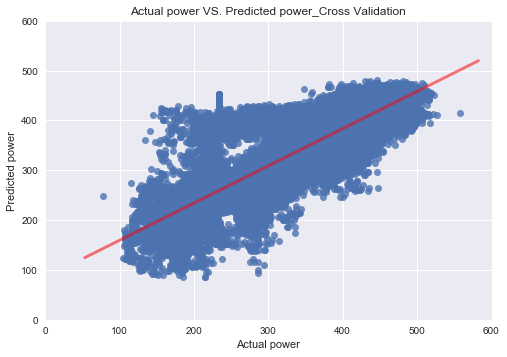

In [64]:
import seaborn as sns
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot = sns.regplot(x="Power (kW)", y="Power_ConsPred_linearReg_CV",
                   data=predict_DF_linearReg_CV,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Actual power VS. Predicted power_Cross Validation')
plot.set_xlim([0,600])
plot.set_ylim([0,600])
plot.set_xlabel('Actual power')
plot.set_ylabel('Predicted power')
regline = plot.get_lines()[0];
regline.set_color('red')
plt.show()

In [65]:
R2_score_linearReg_CV = r2_score(predict_DF_linearReg_CV["Power (kW)"],predict_DF_linearReg_CV["Power_ConsPred_linearReg_CV"])
mean_absolute_error_linearReg_CV = mean_absolute_error(predict_DF_linearReg_CV["Power (kW)"],predict_DF_linearReg_CV["Power_ConsPred_linearReg_CV"])
mean_squared_error_linearReg_CV = mean_squared_error(predict_DF_linearReg_CV["Power (kW)"],predict_DF_linearReg_CV["Power_ConsPred_linearReg_CV"])
coeff_variation_linearReg_CV = np.sqrt(metric_mean_squared_error)/predict_DF_linearReg_CV["Power (kW)"].mean()
print "coefficient_variation of cross validation is " + str (coeff_variation_linearReg_CV) 

coefficient_variation of cross validation is 0.142033524192


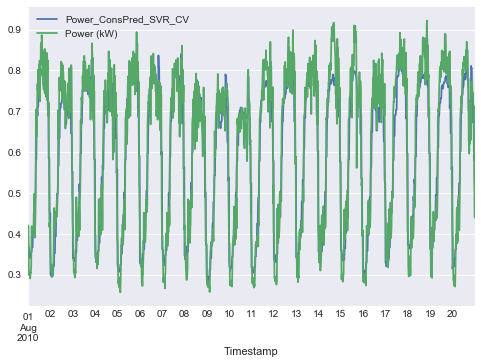

In [81]:
# Method3 support vector machines
from sklearn.svm import SVR
SVR_reg = SVR(kernel='rbf',C=10,gamma=1)
predict_SVR_CV = cross_val_predict(SVR_reg,DF_features_norm,DF_target_norm,cv=10)
predict_DF_SVR_CV=pd.DataFrame(predict_SVR_CV, index = DF_target_norm.index,columns=["Power_ConsPred_SVR_CV"])
predict_DF_SVR_CV = predict_DF_SVR_CV.join(DF_target_norm).dropna()
predict_DF_SVR_CV['2010-08-01':'2010-08-20'].plot()
plt.show()

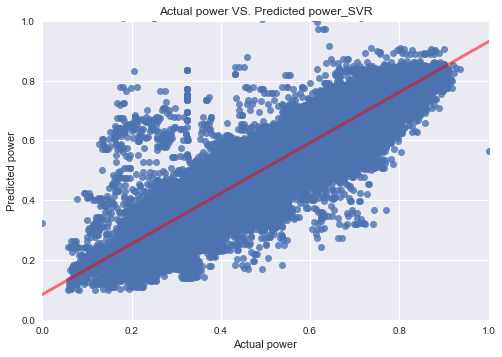

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot = sns.regplot(x="Power (kW)", y="Power_ConsPred_SVR_CV",
                   data=predict_DF_SVR_CV,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Actual power VS. Predicted power_SVR')
plot.set_xlim([0,1])
plot.set_ylim([0,1])
plot.set_xlabel('Actual power')
plot.set_ylabel('Predicted power')
regline = plot.get_lines()[0];
regline.set_color('red')
plt.show()

In [83]:
R2_score_DF_SVR_CV = r2_score(predict_DF_SVR_CV["Power (kW)"],predict_DF_SVR_CV["Power_ConsPred_SVR_CV"])
mean_absolute_error_SVR_CV = mean_absolute_error(predict_DF_SVR_CV["Power (kW)"],predict_DF_SVR_CV["Power_ConsPred_SVR_CV"])
mean_squared_error_SVR_CV = mean_squared_error(predict_DF_SVR_CV["Power (kW)"],predict_DF_SVR_CV["Power_ConsPred_SVR_CV"])
coeff_variation_SVR_CV = np.sqrt(mean_squared_error_SVR_CV)/predict_DF_SVR_CV["Power (kW)"].mean()
print "coefficient_variation of support vector machines is " + str (coeff_variation_SVR_CV) 

coefficient_variation of support vector machines is 0.17176722982


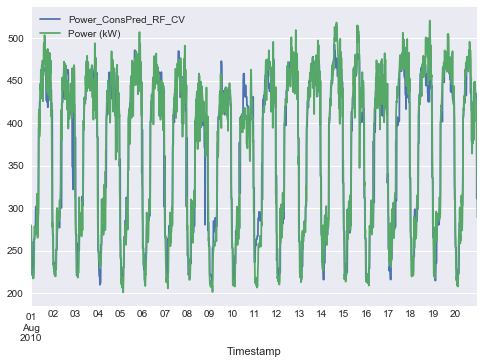

In [87]:
#Method 4
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor()
predict_RF_CV = cross_val_predict(reg_RF,DF_features,DF_target,cv=10)
predict_DF_RF_CV=pd.DataFrame(predict_RF_CV, index = DF_target.index,columns=["Power_ConsPred_RF_CV"])
predict_DF_RF_CV = predict_DF_RF_CV.join(DF_target).dropna()
predict_DF_RF_CV['2010-08-01':'2010-08-20'].plot()
plt.show()

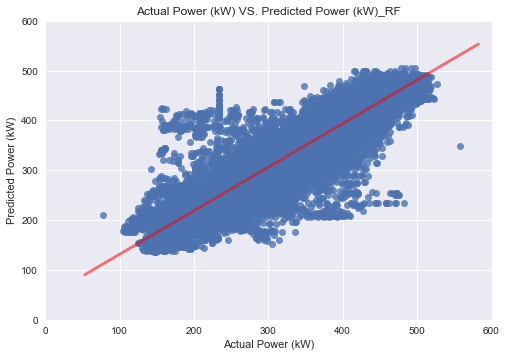

In [85]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot = sns.regplot(x="Power (kW)", y="Power_ConsPred_RF_CV",
                   data=predict_DF_RF_CV,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Actual Power (kW) VS. Predicted Power (kW)_RF')
plot.set_xlim([0,600])
plot.set_ylim([0,600])
plot.set_xlabel('Actual Power (kW)')
plot.set_ylabel('Predicted Power (kW)')
regline = plot.get_lines()[0];
regline.set_color('red')
plt.show()

In [86]:
R2_score_DF_RF_CV = r2_score(predict_DF_RF_CV["Power (kW)"],predict_DF_RF_CV["Power_ConsPred_RF_CV"])
mean_absolute_error_DF_CV = mean_absolute_error(predict_DF_RF_CV["Power (kW)"],predict_DF_RF_CV["Power_ConsPred_RF_CV"])
mean_squared_error_DF_CV = mean_squared_error(predict_DF_RF_CV["Power (kW)"],predict_DF_RF_CV["Power_ConsPred_RF_CV"])
coeff_variation_DF_CV = np.sqrt(mean_squared_error_DF_CV)/predict_DF_RF_CV["Power (kW)"].mean()
print "coefficient_variation of randam forest is " + str (coeff_variation_DF_CV) 

coefficient_variation of randam forest is 0.109133115501


In [92]:
print "The coefficient variation of fouth methods(linear regression split, cross validation, support vector machines and Random Forest Regressor) "+ " are " + str(coeff_variation) + ", " + str(coeff_variation_linearReg_CV ) + ", " + str(coeff_variation_SVR_CV ) + ", " + str (coeff_variation_DF_CV )

The coefficient variation of fouth methods(linear regression split, cross validation, support vector machines and Random Forest Regressor)  are 0.142520913495, 0.142033524192, 0.17176722982, 0.109133115501


In this case, we can see random forest regression method is the most accurate method in predicting the power consumption.